## Plot feature distribution over time

In [42]:
import pandas as pd

races_df = pd.read_csv("../data/races.csv")

races_df

,Unnamed: 0,date_time,race_id,n_runners,horse_id,current_odds,current_place_odds,place,has_won,relevance,...,Class_Difference,Purse,Average_Place_Lifetime,Average_Place_Track,Does_Head_To_Head,Has_Blinker,Jockey_Weight,Max_Past_Rating,Weight_Allowance,Average_Place_Surface
0,0,2022-01-31 14:00:00,4775619,9,43176108,4.50,1.70,6,0,9,...,0.0,7212.500000,2.375000,NaN,0,0,77.1,119.0,2.3,3.166667
1,1,2022-01-31 14:00:00,4775619,9,43176109,8.50,2.50,2,0,30,...,0.0,12043.333333,4.500000,3.000000,0,0,75.3,114.0,0.0,4.250000
2,2,2022-01-31 14:00:00,4775619,9,43176110,1.83,1.17,1,1,30,...,2.0,9540.000000,2.000000,NaN,0,0,73.0,112.0,0.0,2.500000
3,3,2022-01-31 14:00:00,4775619,9,43176111,51.00,11.00,3,0,15,...,0.0,6071.428571,5.857143,8.000000,0,0,72.6,111.0,0.0,5.857143
4,4,2022-01-31 14:00:00,4775619,9,43176112,9.00,2.60,9,0,0,...,0.0,15750.000000,4.250000,NaN,0,0,71.2,NaN,0.0,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63039,63039,2022-09-01 20:30:00,5325671,10,48202477,3.75,1.55,4,0,26,...,-1.0,12768.085106,5.127660,1.000000,0,0,58.1,104.0,0.0,4.903226
63040,63040,2022-09-01 20:30:00,5325671,10,48202478,11.00,3.00,9,0,22,...,0.0,19355.555556,4.333333,NaN,0,0,55.3,83.0,0.0,6.000000
63041,63041,2022-09-01 20:30:00,5325671,10,48202479,12.00,3.20,5,0,25,...,-1.0,13485.714286,3.000000,NaN,0,0,53.5,80.0,0.0,3.500000
63042,63042,2022-09-01 20:30:00,5325671,10,48202481,10.00,2.80,1,1,30,...,0.0,24800.000000,4.300000,NaN,0,0,52.6,NaN,0.0,4.300000


                  std
year-month           
2022-01     33.707457
2022-02     33.772309
2022-03     30.707302
2022-04     28.403029
2022-05     26.722937
2022-06     23.964546
2022-07     22.507945
2022-08     21.670827
2022-09     23.175063


<AxesSubplot:xlabel='Current_Speed_Figure', ylabel='year-month'>

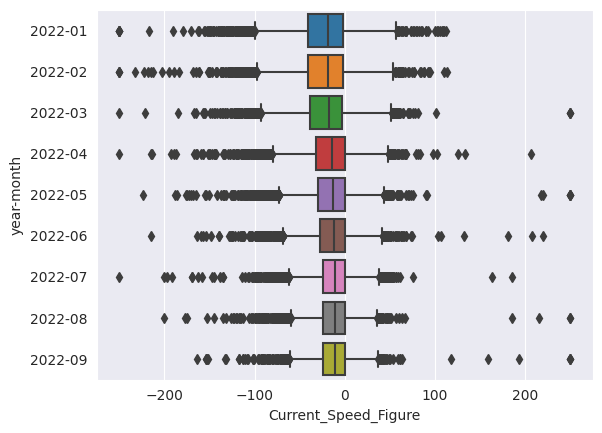

In [45]:
import seaborn as sns

races_df["year-month"] = races_df["date_time"].astype(str).str[:7]
races_df["date"] = pd.to_datetime(races_df["date_time"], format='%Y-%m-%d')
races_df["dayofweek"] = races_df["date"].dt.dayofweek.astype(str)
races_df["hour"] = races_df["date"].dt.hour.astype(str)
races_df["month"] = races_df["date"].dt.month.astype(str)

print(races_df.groupby(["year-month"]).agg(std=("Current_Speed_Figure", "std")))

sns.boxplot(data=races_df, x="Current_Speed_Figure", y="year-month")

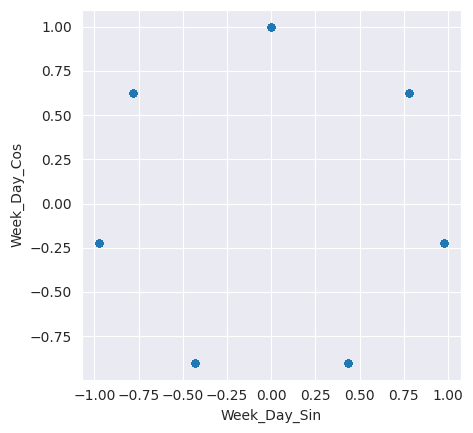

In [8]:
races_df.sample(400).plot.scatter('Week_Day_Sin','Week_Day_Cos').set_aspect('equal');